In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import seaborn as sb

In [38]:
import sklearn as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [4]:
from scipy.sparse import dok_matrix, csr_matrix

In [5]:
tr = pd.read_csv('../data/train.csv')
tr.head(5)

,mid,radiant_won
0,44380,1
1,19687,1
2,10801,0
3,32220,1
4,23207,1


In [6]:
ts = pd.read_csv('../data/test.csv')
ts.head(5)

,mid
0,36193
1,7390
2,1018
3,2960
4,27102


In [7]:
hr = pd.read_csv('../data/heroes.csv')
hr.head(5)

,mid,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,91,42,87,15,65,11,6,34,69,74
1,1,69,85,71,24,64,74,68,39,65,11
2,2,17,40,31,67,99,32,7,72,48,104
3,4,25,15,75,29,95,3,32,55,64,86
4,5,65,6,81,25,71,75,42,101,96,109


In [8]:
hrtr = pd.merge(tr, hr, on = 'mid')
hrts = pd.merge(ts, hr, on = 'mid')

In [9]:
hrtr.head(5)

,mid,radiant_won,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,44380,1,76,96,92,72,64,15,86,75,29,11
1,19687,1,1,64,90,29,11,71,101,74,86,66
2,10801,0,35,75,41,110,19,7,69,86,11,72
3,32220,1,106,11,76,6,77,104,18,96,64,55
4,23207,1,8,75,1,88,69,11,39,82,24,55


In [10]:
hrts.head(5)

,mid,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,36193,64,50,3,75,71,81,90,92,44,94
1,7390,3,1,89,15,64,26,14,33,87,86
2,1018,61,96,13,82,32,102,28,90,107,46
3,2960,27,3,101,15,44,20,21,90,5,29
4,27102,15,101,69,3,104,49,66,67,81,16


In [11]:
radt = ['player_{i}'.format(i = i) for i in range(0, 5)]
dire = ['player_{i}'.format(i = i) for i in range(5, 10)]

In [12]:
cmnd = [*radt, *dire]

In [13]:
nheroes = len(np.unique(hrtr[cmnd].to_numpy()))
nheroes

111

In [14]:
def to_csr(data, nheroes = None):
    nhrs = len(np.unique(hrtr[cmnd].to_numpy())) if nheroes is None else nheroes
    nrows, ncols = data[cmnd].shape
    dradt, ddire = data[radt].to_numpy(), data[dire].to_numpy()
    mod_data = np.hstack((dradt, ddire + nhrs))
    frows = np.repeat(data.index.to_numpy(), ncols)
    fcols = mod_data.reshape(ncols * nrows)
    return csr_matrix((np.ones(ncols * nrows, dtype = np.float32), (frows, fcols)))

In [15]:
csr_hrtr, csr_hrts = to_csr(hrtr), to_csr(hrts)

In [16]:
csr_hrtr.shape

(14984, 222)

In [17]:
hrtr_res = hrtr['radiant_won']

In [18]:
hrtr.shape

(14984, 12)

In [19]:
border = 12000
train_data, train_labels = csr_hrtr[:border, :], hrtr_res[:border]
test_data, test_labels = csr_hrtr[border:, :], hrtr_res[border:]

In [20]:
train_data.shape

(12000, 222)

In [21]:
n_jobs = 16

In [22]:
def weights(distances):
    res = np.ones(distances.shape)
    #not to take into account the point itself
    res[:, 0] = 0.
    return res

In [23]:
#by hyper-parameter search
def fit_pre_model(X, y):
    svc_mod = SVC()
    knn_mod = KNeighborsClassifier(algorithm = 'brute', n_jobs = n_jobs, weights = weights, n_neighbors = 74)
    rfc_mod = RandomForestClassifier(n_jobs = n_jobs, n_estimators = 180)
    gbc_mod = GradientBoostingClassifier(n_estimators = 185)
    lrc_mod = LogisticRegression(n_jobs = n_jobs, C = 0.01)
    res = [rfc_mod, gbc_mod, svc_mod, knn_mod, lrc_mod]
    for m in res:
        m.fit(X, y)
    return res

In [24]:
model = fit_pre_model(train_data, train_labels)

In [25]:
model

[RandomForestClassifier(n_estimators=180, n_jobs=16),
 GradientBoostingClassifier(n_estimators=185),
 SVC(),
 KNeighborsClassifier(algorithm='brute', n_jobs=16, n_neighbors=74,
                      weights=<function weights at 0x7fe51f82d820>),
 LogisticRegression(C=0.01, n_jobs=16)]

In [26]:
def predict_pre_model(model, X):
    preds = [m.predict(X) for m in model]
    return np.array(preds)

In [27]:
trpreds = predict_pre_model(model, train_data).T

In [28]:
tspreds = predict_pre_model(model, test_data).T

In [29]:
trpreds

array([[1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 1, 0, 1, 1],
       ...,
       [1, 0, 1, 0, 0],
       [0, 1, 0, 1, 1],
       [0, 1, 0, 1, 1]])

In [30]:
from sklearn.covariance import EmpiricalCovariance

In [31]:
cm = EmpiricalCovariance().fit(np.hstack((trpreds, train_labels[:, np.newaxis])))

<ipython-input-31-fe65b26a6289>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cm = EmpiricalCovariance().fit(np.hstack((trpreds, train_labels[:, np.newaxis])))


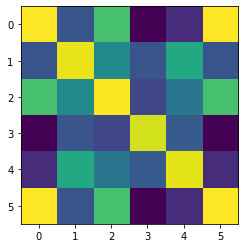

In [32]:
plt.imshow(cm.covariance_)

In [33]:
np.min(cm.covariance_)

0.029147416666666676

In [39]:
res = []
nes = [*range(1, 200)]
#nes = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1., 2., 3., 5., 10., 15., 25., 100.]
for ne in nes:
    model = VotingClassifier(n_jobs = n_jobs)
    model.fit(trpreds, train_labels)
    pr = model.predict(tspreds)
    res.append(roc_auc_score(test_labels, pr))
    print(ne, res[-1])

TypeError: __init__() missing 1 required positional argument: 'estimators'